In [1]:
import time
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import classification_report, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.pipeline import Pipeline
from statistics import mean
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve,auc, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
sns.set_theme()
%matplotlib inline 
warnings.filterwarnings('always')
warnings.simplefilter("always")
warnings.filterwarnings('ignore',category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [2]:
stateful_df = pd.read_csv("Data/Prepared Data/stateful.csv")
stateless_df = pd.read_csv("Data/Prepared Data/stateless.csv")

In [3]:
for col in stateless_df.columns:
    print(f"Percentage of missing values in {col} : {stateless_df[col].isna().sum()/stateless_df.shape[0]}")

Percentage of missing values in timestamp : 0.0
Percentage of missing values in FQDN_count : 0.0
Percentage of missing values in subdomain_length : 0.0
Percentage of missing values in upper : 0.0
Percentage of missing values in lower : 0.0
Percentage of missing values in numeric : 0.0
Percentage of missing values in entropy : 0.0
Percentage of missing values in special : 0.0
Percentage of missing values in labels : 0.0
Percentage of missing values in labels_max : 0.0
Percentage of missing values in labels_average : 0.0
Percentage of missing values in longest_word : 4.093971165236638e-05
Percentage of missing values in sld : 0.0
Percentage of missing values in len : 0.0
Percentage of missing values in subdomain : 0.0
Percentage of missing values in original_index : 0.0
Percentage of missing values in data_type : 0.0
Percentage of missing values in attack : 0.0
Percentage of missing values in origin : 0.0


In [4]:
stateless_df = stateless_df.fillna("")

# Stateless Model - Reimplementation

Training time elapsed: 182.29
Train Accuracy: 0.4090229262688026
Test Accuracy: 0.6941423505873497
Time elapsed: 0.41


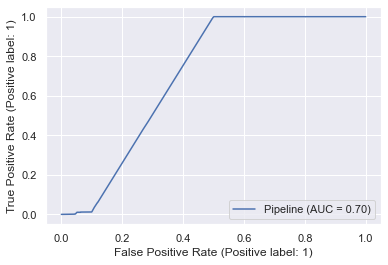

Training time elapsed: 189.90
Train Accuracy: 0.6112660106410199
Test Accuracy: 0.611270321311129
Time elapsed: 0.47


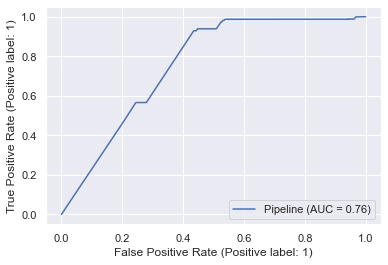

Training time elapsed: 179.24
Train Accuracy: 0.6054634687479881
Test Accuracy: 0.5186011806500178
Time elapsed: 0.31


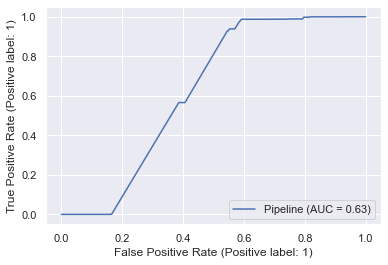

Training time elapsed: 175.32
Train Accuracy: 0.6112676614352996
Test Accuracy: 0.6112637181231099
Time elapsed: 0.32


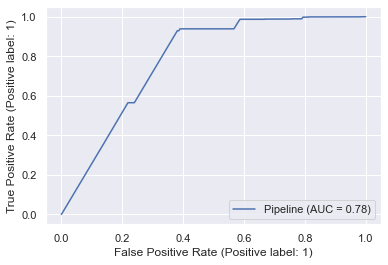

Training time elapsed: 181.14
Train Accuracy: 0.7195284010901846
Test Accuracy: 0.7425483023203603
Time elapsed: 0.39


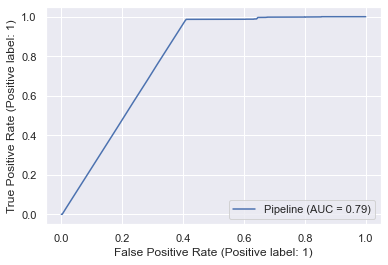

Total time elapsed for predictions: 1.91


In [32]:
stateless_df["Predictions"] = 0
skf = StratifiedKFold(n_splits=5)
X = stateless_df[[col for col in stateless_df.columns \
                  if col not in ["timestamp", "attack", "origin", "data_type", "original_index"]]]
y = stateless_df["attack"]
trained_pipes_svm = []
categorical_transformer_pipes=[]
accuracies = []
total_prediction_time_stateless = 0

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    category_pipeline = ColumnTransformer(
    [
     ('ordinal_encoder', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ["longest_word", "sld"]),
     ('scaler', StandardScaler(), [col for col in X_train if col not in ["longest_word", "sld"]])
     ]
    )
    X_train = category_pipeline.fit_transform(X_train)
    pipe = Pipeline([
         ('svm', LinearSVC(random_state=0))
    ])    
    time_train_start = time.time()

    pipe.fit(X_train, y_train)
    
    time_train_end = time.time()
    
    print(f"Training time elapsed: {(time_train_end - time_train_start):.2f}")

   # pickle.dump(pipe, open('svm_stateless.pkl', 'wb'))
    start_fold = time.time()
    X_test = category_pipeline.transform(X_test)
    print("Train Accuracy:", pipe.score(X_train, y_train))
    print("Test Accuracy:", pipe.score(X_test, y_test))
    stateless_df.loc[test_index, 'Predictions'] = pipe.predict(X_test)
    
    end_fold = time.time()
    print(f"Time elapsed: {(end_fold - start_fold):.2f}")
    total_prediction_time_stateless += (end_fold - start_fold)
    
    trained_pipes_svm.append(pipe)
    categorical_transformer_pipes.append(category_pipeline)
    svm_disp = RocCurveDisplay.from_estimator(pipe, X_test, y_test)
    plt.show() 
    
print(f"Total time elapsed for predictions: {(total_prediction_time_stateless):.2f}")


In [6]:
print(f"Total prediction time for {stateless_df.shape[0]} rows is {total_prediction_time_stateless:.3f}")
single_datapoint_evaluation_time_stateless = total_prediction_time_stateless/stateless_df.shape[0]
print(f"Time to evaluate a single data point: {single_datapoint_evaluation_time_stateless:.8f}")

Total prediction time for 757211 rows is 3.138
Time to evaluate a single data point: 0.00000414


## Overall Results

In [7]:
display(pd.DataFrame(classification_report(stateless_df["attack"], stateless_df["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.671952,0.788989,0.725783,462858.000000
1,0.543042,0.394312,0.456878,294353.000000
accuracy,0.635565,0.635565,0.635565,0.635565
macro avg,0.607497,0.591651,0.591330,757211.000000
weighted avg,0.621841,0.635565,0.621250,757211.000000


## Light-attack

In [12]:
temp = stateless_df[(stateless_df["origin"]=="light-attack")
                  | (stateless_df["origin"]=="light-benign")]
display(pd.DataFrame(classification_report(temp["attack"], temp["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.999983,0.992828,0.996393,60091.000000
1,0.990003,0.999977,0.994965,42683.000000
accuracy,0.995797,0.995797,0.995797,0.995797
macro avg,0.994993,0.996402,0.995679,102774.000000
weighted avg,0.995838,0.995797,0.995800,102774.000000


## Heavy-attack

In [13]:
temp = stateless_df[(stateless_df["origin"]=="heavy-attack")
                  | (stateless_df["origin"]=="heavy-benign")]
display(pd.DataFrame(classification_report(temp["attack"], temp["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.447459,0.794627,0.572526,181694.000000
1,0.662918,0.291592,0.405028,251670.000000
accuracy,0.502497,0.502497,0.502497,0.502497
macro avg,0.555189,0.543110,0.488777,433364.000000
weighted avg,0.572584,0.502497,0.475254,433364.000000


In [14]:
stateless_df.Predictions.value_counts(normalize=True)

0    0.717734
1    0.282266
Name: Predictions, dtype: float64

# Stateful Model Reimplementation

In [16]:
stateful_df.columns

Index(['rr', 'A_frequency', 'NS_frequency', 'CNAME_frequency', 'SOA_frequency',
       'NULL_frequency', 'PTR_frequency', 'HINFO_frequency', 'MX_frequency',
       'TXT_frequency', 'AAAA_frequency', 'SRV_frequency', 'OPT_frequency',
       'rr_type', 'rr_count', 'rr_name_entropy', 'rr_name_length',
       'distinct_ns', 'distinct_ip', 'unique_country', 'unique_asn',
       'distinct_domains', 'reverse_dns', 'a_records', 'unique_ttl',
       'ttl_mean', 'ttl_variance', 'original_index', 'data_type', 'attack',
       'origin'],
      dtype='object')

Training time elapsed: 47.57
Train Accuracy: 0.5842887392457221
Test Accuracy: 0.5193338547528662
Time elapsed: 0.31


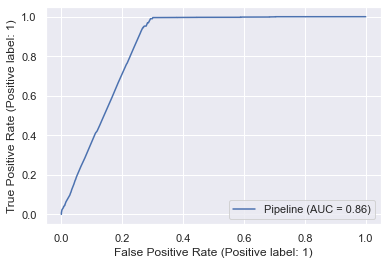

Training time elapsed: 49.15
Train Accuracy: 0.6820978233913889
Test Accuracy: 0.6821121306346694
Time elapsed: 0.23


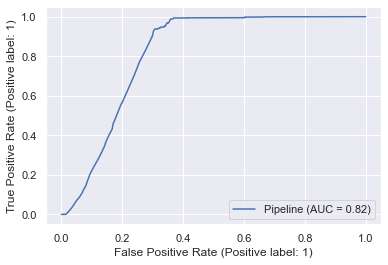

Training time elapsed: 48.89
Train Accuracy: 0.6821025924724824
Test Accuracy: 0.6820930543102955
Time elapsed: 0.24


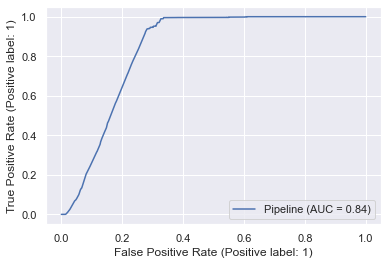

Training time elapsed: 48.58
Train Accuracy: 0.6821025924724824
Test Accuracy: 0.6820930543102955
Time elapsed: 0.25


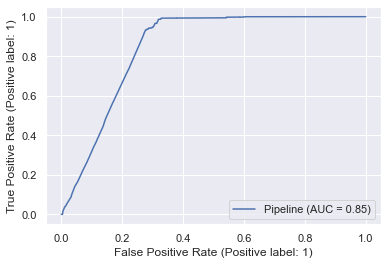

Training time elapsed: 50.25
Train Accuracy: 0.6821025924724824
Test Accuracy: 0.6820930543102955
Time elapsed: 0.23


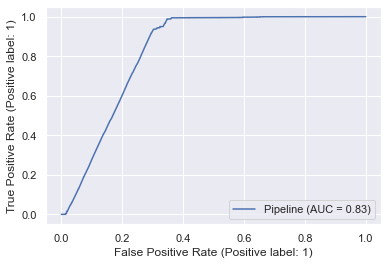

Total time elapsed for predictions: 1.26


In [21]:
stateful_df["Predictions"] = 0
skf = StratifiedKFold(n_splits=5)
categorical_features = ["rr_type", "distinct_ip", "unique_country",
"unique_asn", "distinct_domains", "reverse_dns"]
X = stateful_df[[col for col in stateful_df.columns \
                 if col not in ["unique_ttl", "attack", "origin", "data_type", "original_index"]]]
y = stateful_df["attack"]
trained_pipes_svm = []
categorical_transformer_pipes=[]
accuracies = []
total_prediction_time_stateful = 0

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    category_pipeline = ColumnTransformer(
    [
     ('ordinal_encoder', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical_features),
     ('scaler', StandardScaler(), [col for col in X_train if col not in categorical_features])
     ]
    )
    X_train = category_pipeline.fit_transform(X_train)
    pipe = Pipeline([
        ('svm', LinearSVC(random_state=0))
    ])
    
    time_train_start = time.time()

    pipe.fit(X_train, y_train)
    
    time_train_end = time.time()
    
    print(f"Training time elapsed: {(time_train_end - time_train_start):.2f}")
    
    # pickle.dump(pipe, open('svm_stateless.pkl', 'wb'))
    

    start_fold = time.time()
    X_test = category_pipeline.transform(X_test)
    #print(X_test)
    print("Train Accuracy:", pipe.score(X_train, y_train))
    print("Test Accuracy:", pipe.score(X_test, y_test))
    stateful_df.loc[test_index, 'Predictions'] = pipe.predict(X_test)
    
    end_fold = time.time()
    print(f"Time elapsed: {(end_fold - start_fold):.2f}")
    total_prediction_time_stateful += (end_fold - start_fold)
    
    trained_pipes_svm.append(pipe)
    categorical_transformer_pipes.append(category_pipeline)


    #display(pd.DataFrame(classification_report(y_test, pipe.predict(X_test), output_dict=True)).T)
    svm_disp = RocCurveDisplay.from_estimator(pipe, X_test, y_test)
    plt.show()  
print(f"Total time elapsed for predictions: {(total_prediction_time_stateful):.2f}")
    

In [22]:
print(f"Total prediction time for {stateless_df.shape[0]} rows is {total_prediction_time_stateful:.3f}")
single_datapoint_evaluation_time_stateful = total_prediction_time_stateful/stateless_df.shape[0]
print(f"Time to evaluate a single data point: {single_datapoint_evaluation_time_stateful:.8f}")

Total prediction time for 757211 rows is 1.263
Time to evaluate a single data point: 0.00000167


## Overall Results

In [23]:
display(pd.DataFrame(classification_report(stateful_df["attack"], stateful_df["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.697337,0.859074,0.769802,178782.000000
1,0.398070,0.199969,0.266209,83323.000000
accuracy,0.649545,0.649545,0.649545,0.649545
macro avg,0.547703,0.529521,0.518005,262105.000000
weighted avg,0.602200,0.649545,0.609710,262105.000000


## Light Attack Results

In [24]:
temp = stateful_df[(stateful_df["origin"]=="light-attack")
                  | (stateful_df["origin"]=="light-benign")]
display(pd.DataFrame(classification_report(temp["attack"], temp["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.999912,1.000000,0.999956,22768.000000
1,1.000000,0.999823,0.999911,11295.000000
accuracy,0.999941,0.999941,0.999941,0.999941
macro avg,0.999956,0.999911,0.999934,34063.000000
weighted avg,0.999941,0.999941,0.999941,34063.000000


## Heavy Attack Results

In [25]:
temp = stateful_df[(stateful_df["origin"]=="heavy-attack")
                  | (stateful_df["origin"]=="heavy-benign")]
display(pd.DataFrame(classification_report(temp["attack"], temp["Predictions"], output_dict=True)).T)

,precision,recall,f1-score,support
0,0.508686,1.000000,0.674343,69016.000000
1,1.000000,0.074540,0.138739,72028.000000
accuracy,0.527389,0.527389,0.527389,0.527389
macro avg,0.754343,0.537270,0.406541,141044.000000
weighted avg,0.759589,0.527389,0.400822,141044.000000


In [26]:
stateful_df.origin.value_counts()

only-benign     86998
heavy-attack    72028
heavy-benign    69016
light-benign    22768
light-attack    11295
Name: origin, dtype: int64

## TWO STEP MODEL

In [28]:
WINDOW_SIZE=100
SUSPICIOUS_THRESHOLD = 0.4
ATTACK_THRESHOLD = 0.7

In [29]:
def two_step(stateless_df, stateful_df, is_light=True):
    estimated_time = 0
       
    if is_light:
        light_or_heavy_string = "light"
    else:
        light_or_heavy_string = "heavy"
        
    stateless_df_subset = stateless_df[stateless_df.origin.isin([light_or_heavy_string+"-benign", light_or_heavy_string+"-attack"])].reset_index()
    stateless_df_subset["Final_two_step_prediction"] = stateless_df_subset["Predictions"]
    stateful_df_subset = stateful_df[stateful_df.origin.isin([light_or_heavy_string+"-benign", light_or_heavy_string+"-attack"])].reset_index()
    stateful_df_subset["Final_two_step_prediction"] = stateful_df_subset["Predictions"] 
    stateful_df_subset['unique_ttl'] = stateful_df_subset['unique_ttl'].apply(ast.literal_eval)
    stateful_df_subset = stateful_df_subset.explode("unique_ttl")

    time_windows = []
    attack_ratios = []

    for i in range(0, stateless_df_subset.shape[0], WINDOW_SIZE):
        current_data = stateless_df_subset.iloc[i:i+WINDOW_SIZE]
        attack_ratio = (current_data[current_data["Predictions"]==1].shape[0]/current_data.shape[0])
        time_windows.append(i)
        attack_ratios.append(attack_ratio)
        estimated_time += (single_datapoint_evaluation_time_stateless * WINDOW_SIZE)
        if attack_ratio >= ATTACK_THRESHOLD:
            stateless_df_subset.loc[[i for i in range(i, min(i+WINDOW_SIZE, stateless_df_subset.shape[0]))], 'Final_two_step_prediction'] = 1
        elif attack_ratio < SUSPICIOUS_THRESHOLD:
            stateless_df_subset.loc[[i for i in range(i, min(i+WINDOW_SIZE, stateless_df_subset.shape[0]))], 'Final_two_step_prediction'] = 0
        else:
            estimated_time += (single_datapoint_evaluation_time_stateful * WINDOW_SIZE)
            stateful_data_window = stateful_df_subset.iloc[i:i+WINDOW_SIZE]
            stateful_attack_ratio = (stateful_data_window[stateful_data_window["Predictions"]==1].shape[0]/stateful_data_window.shape[0])
            if stateful_attack_ratio >= 0.5:
                stateless_df_subset.loc[[i for i in range(i, min(i+WINDOW_SIZE, stateless_df_subset.shape[0]))], 'Final_two_step_prediction'] = 1
            elif stateful_attack_ratio < 0.5:
                stateless_df_subset.loc[[i for i in range(i, min(i+WINDOW_SIZE, stateless_df_subset.shape[0]))], 'Final_two_step_prediction'] = 0

    plt.plot(time_windows, attack_ratios)
    plt.title("Stateless attack ratio over the 100-datapoint windows")
    plt.show()
    display(pd.DataFrame(classification_report(stateless_df_subset["attack"], stateless_df_subset["Final_two_step_prediction"], output_dict=True)).T)
    print("Total Estimated Time: ", estimated_time)
    

### LIGHT ATTACK

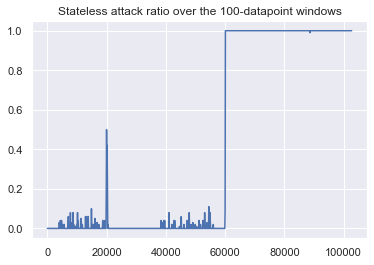

,precision,recall,f1-score,support
0,0.999850,1.000000,0.999925,60091.000000
1,1.000000,0.999789,0.999895,42683.000000
accuracy,0.999912,0.999912,0.999912,0.999912
macro avg,0.999925,0.999895,0.999910,102774.000000
weighted avg,0.999912,0.999912,0.999912,102774.000000


Total Estimated Time:  0.42631679098741854


In [30]:
two_step(stateless_df, stateful_df, is_light=True)

### HEAVY ATTACK

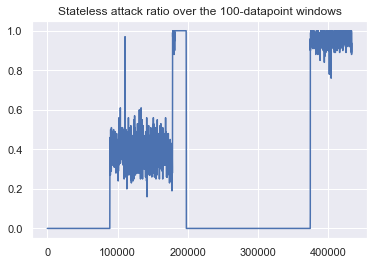

,precision,recall,f1-score,support
0,0.502255,0.980770,0.664313,181694.000000
1,0.955527,0.298287,0.454647,251670.000000
accuracy,0.584428,0.584428,0.584428,0.584428
macro avg,0.728891,0.639529,0.559480,433364.000000
weighted avg,0.765486,0.584428,0.542553,433364.000000


Total Estimated Time:  1.854307800693112


In [31]:
two_step(stateless_df, stateful_df, is_light=False)